In [193]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras

from tensorflow.keras import initializers, Model
from tensorflow.keras.layers import Dense, Layer

import numpy as np
import matplotlib.pyplot as plt

import random
from tqdm import tqdm
import time 

In [194]:
# Hyperparameters
VERBOSE = True
SHUFFLE_SIZE = 1000
BATCH_SIZE = 1
PREFETCH_SIZE = 128
BUFFER_SIZE = 256

# Data

In [195]:
train_ds, test_ds = tfds.load('mnist', split=['train','test'], as_supervised=True)

In [196]:
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

### Show data

In [197]:
def add_noise(images, noise_factor = 0.1, noise_func = "normal"):
    if noise_func == "gaussian":
        sample_noise = keras.layers.GaussianNoise(noise_factor, dtype=tf.float32)
        noisy = sample_noise(images, training = True)
    elif noise_func == "normal":
        noisy = images + noise_factor * tf.random.normal(shape = images.shape)
        noisy = tf.clip_by_value(noisy, clip_value_min = 0., clip_value_max = 1.)
    return noisy

In [198]:
@tf.autograph.experimental.do_not_convert
def preprocess(data, noise_factor = 0.2, prepare = True):
    # Cast Image pixel values as floats
    data = data.map(lambda img, target: (tf.cast(img, tf.float32), target))
    # Normalize pixel values
    data = data.map(lambda img, target: ((img/255), target))
    # Add noise to the data
    data = data.map(lambda img, target: (add_noise(img, noise_factor = noise_factor), target))
    # Apply OneHot to picture labels
    data = data.map(lambda img, target: (img, tf.one_hot(target, 10)))
    # Shuffle, batch and prefetch
    if prepare: data = data.shuffle(SHUFFLE_SIZE).batch(BATCH_SIZE).prefetch(PREFETCH_SIZE)
    return data
    

2021-12-14 11:24:00.609068: W tensorflow/core/kernels/data/cache_dataset_ops.cc:757] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


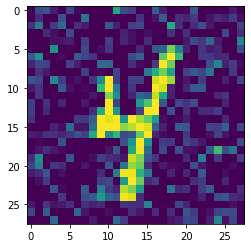

In [205]:
train_ds_image = preprocess(train_ds, noise_factor = 0.2,prepare = False)
train_ds_noisy = preprocess(train_ds)
test_ds_noisy = preprocess(test_ds)

for image, label in train_ds_image.take(1):
    plt.imshow(image)

# Model

### Convolutional Autoencoder